In [1]:
import os
import os.path as path
import gc
import re
import math
import json
import random

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
pd.set_option('display.max_row', 50)
pd.set_option('display.max_columns', 100)

In [7]:
# 디렉토리 기본 경로 설정
DIR_PATH = path.join('..')
DIR_SAVE_PATH = path.join('.')

print(DIR_PATH)
print(DIR_SAVE_PATH)

..
.


In [8]:
# bean_raw_data.csv
user_read = pd.read_csv(path.join(DIR_PATH, 'user_propensity_data.csv'), low_memory=False)

print(user_read.shape)
user_read.columns = ['timestamp', 'phone', 'cafe', 'preference', 'drink', 'dessert', 'fruit', 'aroma']
user_read.head()

(105, 8)


,timestamp,phone,cafe,preference,drink,dessert,fruit,aroma
0,2023. 3. 24 오후 2:59:41,010-9491-7668,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,2023. 3. 24 오후 3:03:33,010-2840-2336,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,2023. 3. 24 오후 3:03:50,010-9231-9670,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,2023. 3. 24 오후 3:04:09,010-9027-0157,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,2023. 3. 24 오후 3:04:13,010-4404-9238,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기


In [9]:
user_data = user_read.iloc[:, 2:].copy()
user_data.head()

,cafe,preference,drink,dessert,fruit,aroma
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기


In [10]:
cafe_others = (user_data['cafe'] != '스타벅스 Starbucks') \
& (user_data['cafe'] != '투썸플레이스 A TWOSOME PLACE') \
& (user_data['cafe'] != '이디야 커피 EDIYA COFFEE') \
& (user_data['cafe'] != '카페 파스쿠치 CAFFÉ PASCUCCI')

user_data.loc[cafe_others, 'cafe'] = random.choice(['스타벅스 Starbucks', '투썸플레이스 A TWOSOME PLACE', '이디야 커피 EDIYA COFFEE', '카페 파스쿠치 CAFFÉ PASCUCCI'])
user_data.head()

,cafe,preference,drink,dessert,fruit,aroma
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기


In [11]:
user_data['cafe'].value_counts(dropna=False)

스타벅스 Starbucks            60
투썸플레이스 A TWOSOME PLACE    33
이디야 커피 EDIYA COFFEE        7
카페 파스쿠치 CAFFÉ PASCUCCI     5
Name: cafe, dtype: int64

In [12]:
# cafe_list = np.sort(user_data['cafe'].unique()).tolist()
# print(cafe_list)
# preference_list = np.sort(user_data['preference'].unique()).tolist()
# print(preference_list)
# drink_list = np.sort(user_data['drink'].unique()).tolist()
# print(drink_list)
# dessert_list = np.sort(user_data['dessert'].unique()).tolist()
# print(dessert_list)
# fruit_list = np.sort(user_data['fruit'].unique()).tolist()
# print(fruit_list)
# aroma_list = np.sort(user_data['aroma'].unique()).tolist()
# print(aroma_list)

In [13]:
# none, 스벅, 투썸, 파스, 이디야, padding
cafe_list = ['none', '스타벅스 Starbucks', '투썸플레이스 A TWOSOME PLACE', '카페 파스쿠치 CAFFÉ PASCUCCI', '이디야 커피 EDIYA COFFEE', 'padding']
# none, 향, 산미, 단맛, 쓴맛, 목넘김
preference_list = ['none', '향이나 맛이 다른 커피보다 잘 느껴져요', '커피의 새콤한 맛이 도드라져요', '설탕이나 초콜릿 냄새라던가 맛이 선명해요', '커피 특유의 씁쓸한 맛이 잘 나타나요', '다른 커피를 마실때보다 목넘김이 좋아요']
# none, 아메리카노, 카페라떼, 바닐라라떼, 티, padding
drink_list = ['none', '☕에스프레소 또는 아메리카노, 콜드브루', '🥛카페라떼 또는 카푸치노, 마끼아또 (달지않아요)', '🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)', '🌸티 또는 주스', 'padding']
# none, 과일타르트, 초코케이크, 호두파이, padding, padding
dessert_list = ['none', '상큼하고 개운한 과일 타르트', '진하고 달달한 초코 케이크', '담백하고 고소한이 두드러지는 호두파이']
# none, 사과, 복숭아, 베리, 오렌지, 바나나
fruit_list = ['none', '사과, 배', '체리, 복숭아', '크랜베리, 블루베리', '레몬, 오렌지, 귤', '망고, 바나나, 파인애플']
# none, 우디, 시트러스, 허브, 꽃, 허니
aroma_list = ['none', '나무의 우디한 향기', '감귤의 상큼한 향기', '허브의 마음이 진정되는 향기', '꽃의 신선한 향기', '꿀이나 설탕같은 달달한 향기']

In [14]:
if 'cafe_label' in user_data:
    user_data.drop(labels=['cafe_label'], axis=1, inplace=True)

if 'preference_label' in user_data:
    user_data.drop(labels=['preference_label'], axis=1, inplace=True)

if 'drink_label' in user_data:
    user_data.drop(labels=['drink_label'], axis=1, inplace=True)

if 'dessert_label' in user_data:
    user_data.drop(labels=['dessert_label'], axis=1, inplace=True)

if 'fruit_label' in user_data:
    user_data.drop(labels=['fruit_label'], axis=1, inplace=True)

if 'aroma_label' in user_data:
    user_data.drop(labels=['aroma_label'], axis=1, inplace=True)

In [15]:
# user_data.insert(int(user_data.columns.get_indexer(['cafe'])[0] + 1), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)), )
user_data.insert(len(user_data.columns), 'cafe_label', user_data['cafe'].map(lambda x: cafe_list.index(x)))

user_data.insert(len(user_data.columns), 'preference_label', user_data['preference'].map(lambda x: preference_list.index(x)))

user_data.insert(len(user_data.columns), 'drink_label', user_data['drink'].map(lambda x: drink_list.index(x)))

user_data.insert(len(user_data.columns), 'dessert_label', user_data['dessert'].map(lambda x: dessert_list.index(x)))

user_data.insert(len(user_data.columns), 'fruit_label', user_data['fruit'].map(lambda x: fruit_list.index(x)))

user_data.insert(len(user_data.columns), 'aroma_label', user_data['aroma'].map(lambda x: aroma_list.index(x)))

In [16]:
user_data.head()

,cafe,preference,drink,dessert,fruit,aroma,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
0,스타벅스 Starbucks,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"체리, 복숭아",허브의 마음이 진정되는 향기,1,1,1,2,2,3
1,스타벅스 Starbucks,다른 커피를 마실때보다 목넘김이 좋아요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",진하고 달달한 초코 케이크,"사과, 배",꿀이나 설탕같은 달달한 향기,1,5,3,2,1,5
2,투썸플레이스 A TWOSOME PLACE,향이나 맛이 다른 커피보다 잘 느껴져요,"☕에스프레소 또는 아메리카노, 콜드브루",상큼하고 개운한 과일 타르트,"크랜베리, 블루베리",허브의 마음이 진정되는 향기,2,1,1,1,3,3
3,이디야 커피 EDIYA COFFEE,다른 커피를 마실때보다 목넘김이 좋아요,"☕에스프레소 또는 아메리카노, 콜드브루",진하고 달달한 초코 케이크,"레몬, 오렌지, 귤",나무의 우디한 향기,4,5,1,2,4,1
4,스타벅스 Starbucks,설탕이나 초콜릿 냄새라던가 맛이 선명해요,"🍯카페모카 또는 바닐라라떼, 카라멜 마키아또 (달달해요)",상큼하고 개운한 과일 타르트,"사과, 배",꽃의 신선한 향기,1,3,3,1,1,4


In [17]:
survey_transform = np.array([
    # none, 스벅, 투썸, 파스, 이디야, padding
    [[6, 6, 6, 6, 6], [8, 4, 4, 9, 6], [9, 5, 3, 7, 10], [7, 10, 8, 6, 7], [4, 8, 5, 6, 8], [0, 0, 0, 0, 0]],
    # none, 향, 산미, 단맛, 쓴맛, 목넘김
    [[6, 6, 6, 6, 6], [12, 0, 0, 0, 0], [0, 12, 0, 0, 0], [0, 0, 12, 0, 0], [0, 0, 0, 12, 0], [0, 0, 0, 0, 12]],
    # none, 아메리카노, 카페라떼, 바닐라라떼, 티, padding
    [[6, 6, 6, 6, 6], [11, 7, 4, 10, 9], [7, 3, 7, 4, 11], [8, 2, 11, 2, 6], [9, 5, 9, 1, 4], [0, 0, 0, 0, 0]],
    # none, 과일타르트, 초코케이크, 호두파이, padding, padding
    [[6, 6, 6, 6, 6], [11, 9, 8, 2, 4], [5, 2, 12, 4, 9], [7, 0, 4, 7, 12], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]],
    # none, 사과, 복숭아, 베리, 오렌지, 바나나
    [[6, 6, 6, 6, 6], [6, 6, 7, 2, 3], [12, 3, 10, 3, 2], [5, 8, 6, 10, 4], [8, 12, 4, 6, 5], [7, 5, 9, 4, 12]],
    # none, 우디, 시트러스, 허브, 꽃, 허니
    [[6, 6, 6, 6, 6], [5, 1, 1, 9, 12], [8, 12, 4, 1, 5], [10, 4, 4, 12, 5], [12, 3, 3, 3, 4], [9, 0, 12, 0, 6]]
])
survey_transform

array([[[ 6,  6,  6,  6,  6],
        [ 8,  4,  4,  9,  6],
        [ 9,  5,  3,  7, 10],
        [ 7, 10,  8,  6,  7],
        [ 4,  8,  5,  6,  8],
        [ 0,  0,  0,  0,  0]],

       [[ 6,  6,  6,  6,  6],
        [12,  0,  0,  0,  0],
        [ 0, 12,  0,  0,  0],
        [ 0,  0, 12,  0,  0],
        [ 0,  0,  0, 12,  0],
        [ 0,  0,  0,  0, 12]],

       [[ 6,  6,  6,  6,  6],
        [11,  7,  4, 10,  9],
        [ 7,  3,  7,  4, 11],
        [ 8,  2, 11,  2,  6],
        [ 9,  5,  9,  1,  4],
        [ 0,  0,  0,  0,  0]],

       [[ 6,  6,  6,  6,  6],
        [11,  9,  8,  2,  4],
        [ 5,  2, 12,  4,  9],
        [ 7,  0,  4,  7, 12],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 6,  6,  6,  6,  6],
        [ 6,  6,  7,  2,  3],
        [12,  3, 10,  3,  2],
        [ 5,  8,  6, 10,  4],
        [ 8, 12,  4,  6,  5],
        [ 7,  5,  9,  4, 12]],

       [[ 6,  6,  6,  6,  6],
        [ 5,  1,  1,  9, 12],
        [ 8, 12,  4,  1,  5],


In [18]:
user_label = user_data.iloc[:, 6:].copy()
user_label.head()

,cafe_label,preference_label,drink_label,dessert_label,fruit_label,aroma_label
0,1,1,1,2,2,3
1,1,5,3,2,1,5
2,2,1,1,1,3,3
3,4,5,1,2,4,1
4,1,3,3,1,1,4


In [19]:
list(enumerate([x for x in user_label.iloc[0, :]]))

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 3)]

In [20]:
def label_transform(idx, matrix, transform):
    tf_sum = np.array([0,0,0,0,0])
    for i, j in list(enumerate([x for x in matrix.iloc[idx, :]])):
        tf_sum += transform[i][j]
        # print(transform[i][j])

    tf_mean = (tf_sum/(6*6*2)*10).round(1)
    # print(tf_mean)
    return tf_mean

In [21]:
user_label.apply(lambda x: label_transform(x.name, user_label, survey_transform), axis=1)

0      [8.1, 2.8, 4.7, 5.3, 4.3]
1      [5.0, 1.9, 6.4, 2.4, 5.8]
2      [8.1, 4.6, 3.5, 5.7, 4.4]
3      [4.6, 4.2, 3.6, 4.9, 7.6]
4      [6.2, 3.3, 6.2, 2.5, 3.2]
                 ...            
100    [6.2, 5.7, 3.6, 4.2, 5.1]
101    [5.4, 5.1, 3.1, 6.2, 5.3]
102    [4.6, 3.9, 4.3, 5.4, 7.4]
103    [6.1, 4.6, 3.3, 5.6, 6.7]
104    [7.6, 2.9, 3.6, 3.8, 4.6]
Length: 105, dtype: object

In [22]:
label_columns = ['flavor', 'acidity', 'sweetness', 'bitterness', 'body']
user_label_tf_df = pd.DataFrame(columns=label_columns)
user_label_tf = user_label.apply(lambda x: label_transform(x.name, user_label, survey_transform), axis=1)
user_label_tf_df = user_label_tf.apply(lambda x: pd.Series(x, index=label_columns))

In [23]:
user_label_tf_df.head()

,flavor,acidity,sweetness,bitterness,body
0,8.1,2.8,4.7,5.3,4.3
1,5.0,1.9,6.4,2.4,5.8
2,8.1,4.6,3.5,5.7,4.4
3,4.6,4.2,3.6,4.9,7.6
4,6.2,3.3,6.2,2.5,3.2


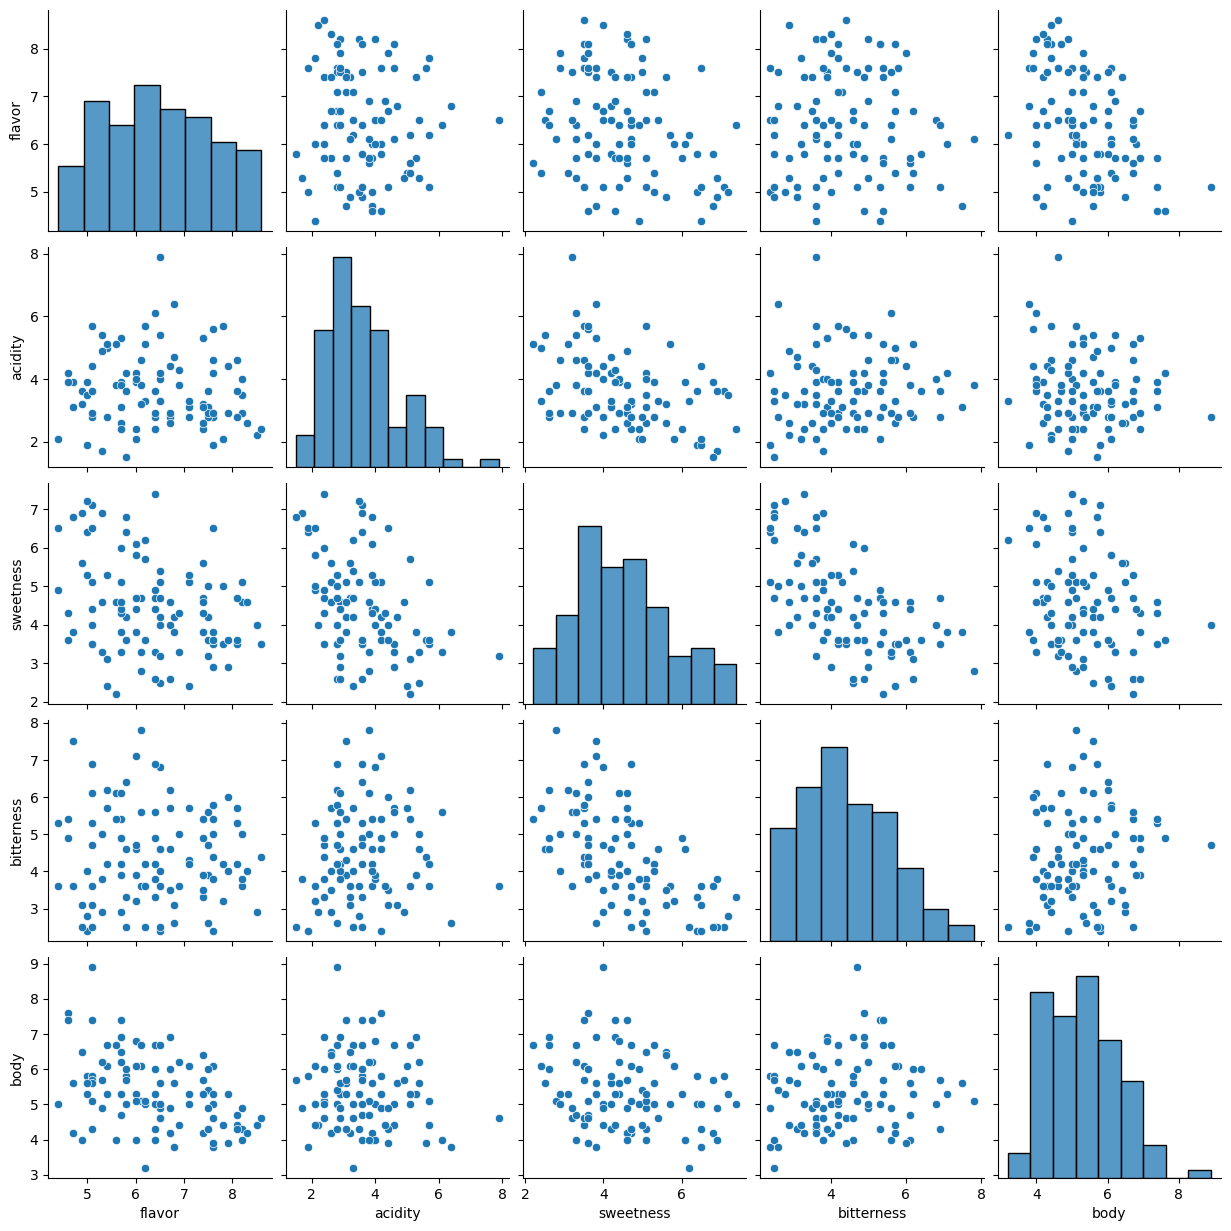

In [24]:
sns.pairplot(user_label_tf_df)

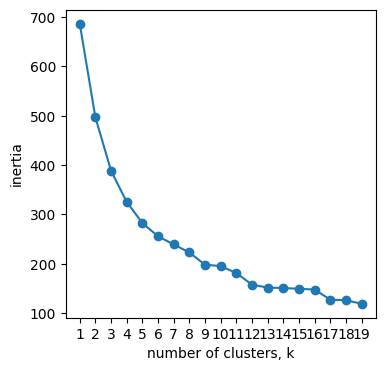

In [25]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(user_label_tf_df)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [26]:
# K-Means 모델과 군집 예측값을 생성

# 클러스터 모델 생성 파라미터는 원할 경우 추가
clust_model = KMeans(n_clusters = 4, n_init='auto'
#                      , max_iter=500 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다
#                      , random_state = 42
#                      , algorithm='auto'
                    )

# 생성한 모델로 데이터를 학습시킴
clust_model.fit(user_label_tf_df) # unsupervised learning 

# 결과 값을 변수에 저장
centers = clust_model.cluster_centers_ # 각 군집의 중심점
pred = clust_model.predict(user_label_tf_df) # 각 예측군집

print(pd.DataFrame(centers))
print(pred[:10])

          0         1         2         3         4
0  6.944444  5.311111  3.683333  4.266667  4.861111
1  7.540741  2.937037  4.403704  4.277778  4.762963
2  5.828125  3.656250  3.609375  5.693750  6.118750
3  5.728571  3.075000  5.996429  3.239286  5.342857
[1 3 0 2 3 2 1 1 2 2]


In [27]:
# 원래 데이터에 예측된 군집 붙이기
user_label_tf_clust_df = user_label_tf_df.copy()
user_label_tf_clust_df['clust'] = pred
user_label_tf_clust_df.head()

,flavor,acidity,sweetness,bitterness,body,clust
0,8.1,2.8,4.7,5.3,4.3,1
1,5.0,1.9,6.4,2.4,5.8,3
2,8.1,4.6,3.5,5.7,4.4,0
3,4.6,4.2,3.6,4.9,7.6,2
4,6.2,3.3,6.2,2.5,3.2,3


In [28]:
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    print(str(center) + ' ' + color)

[6.94444444 5.31111111 3.68333333 4.26666667 4.86111111] tab:blue
[7.54074074 2.93703704 4.4037037  4.27777778 4.76296296] tab:orange
[5.828125 3.65625  3.609375 5.69375  6.11875 ] tab:green
[5.72857143 3.075      5.99642857 3.23928571 5.34285714] tab:red


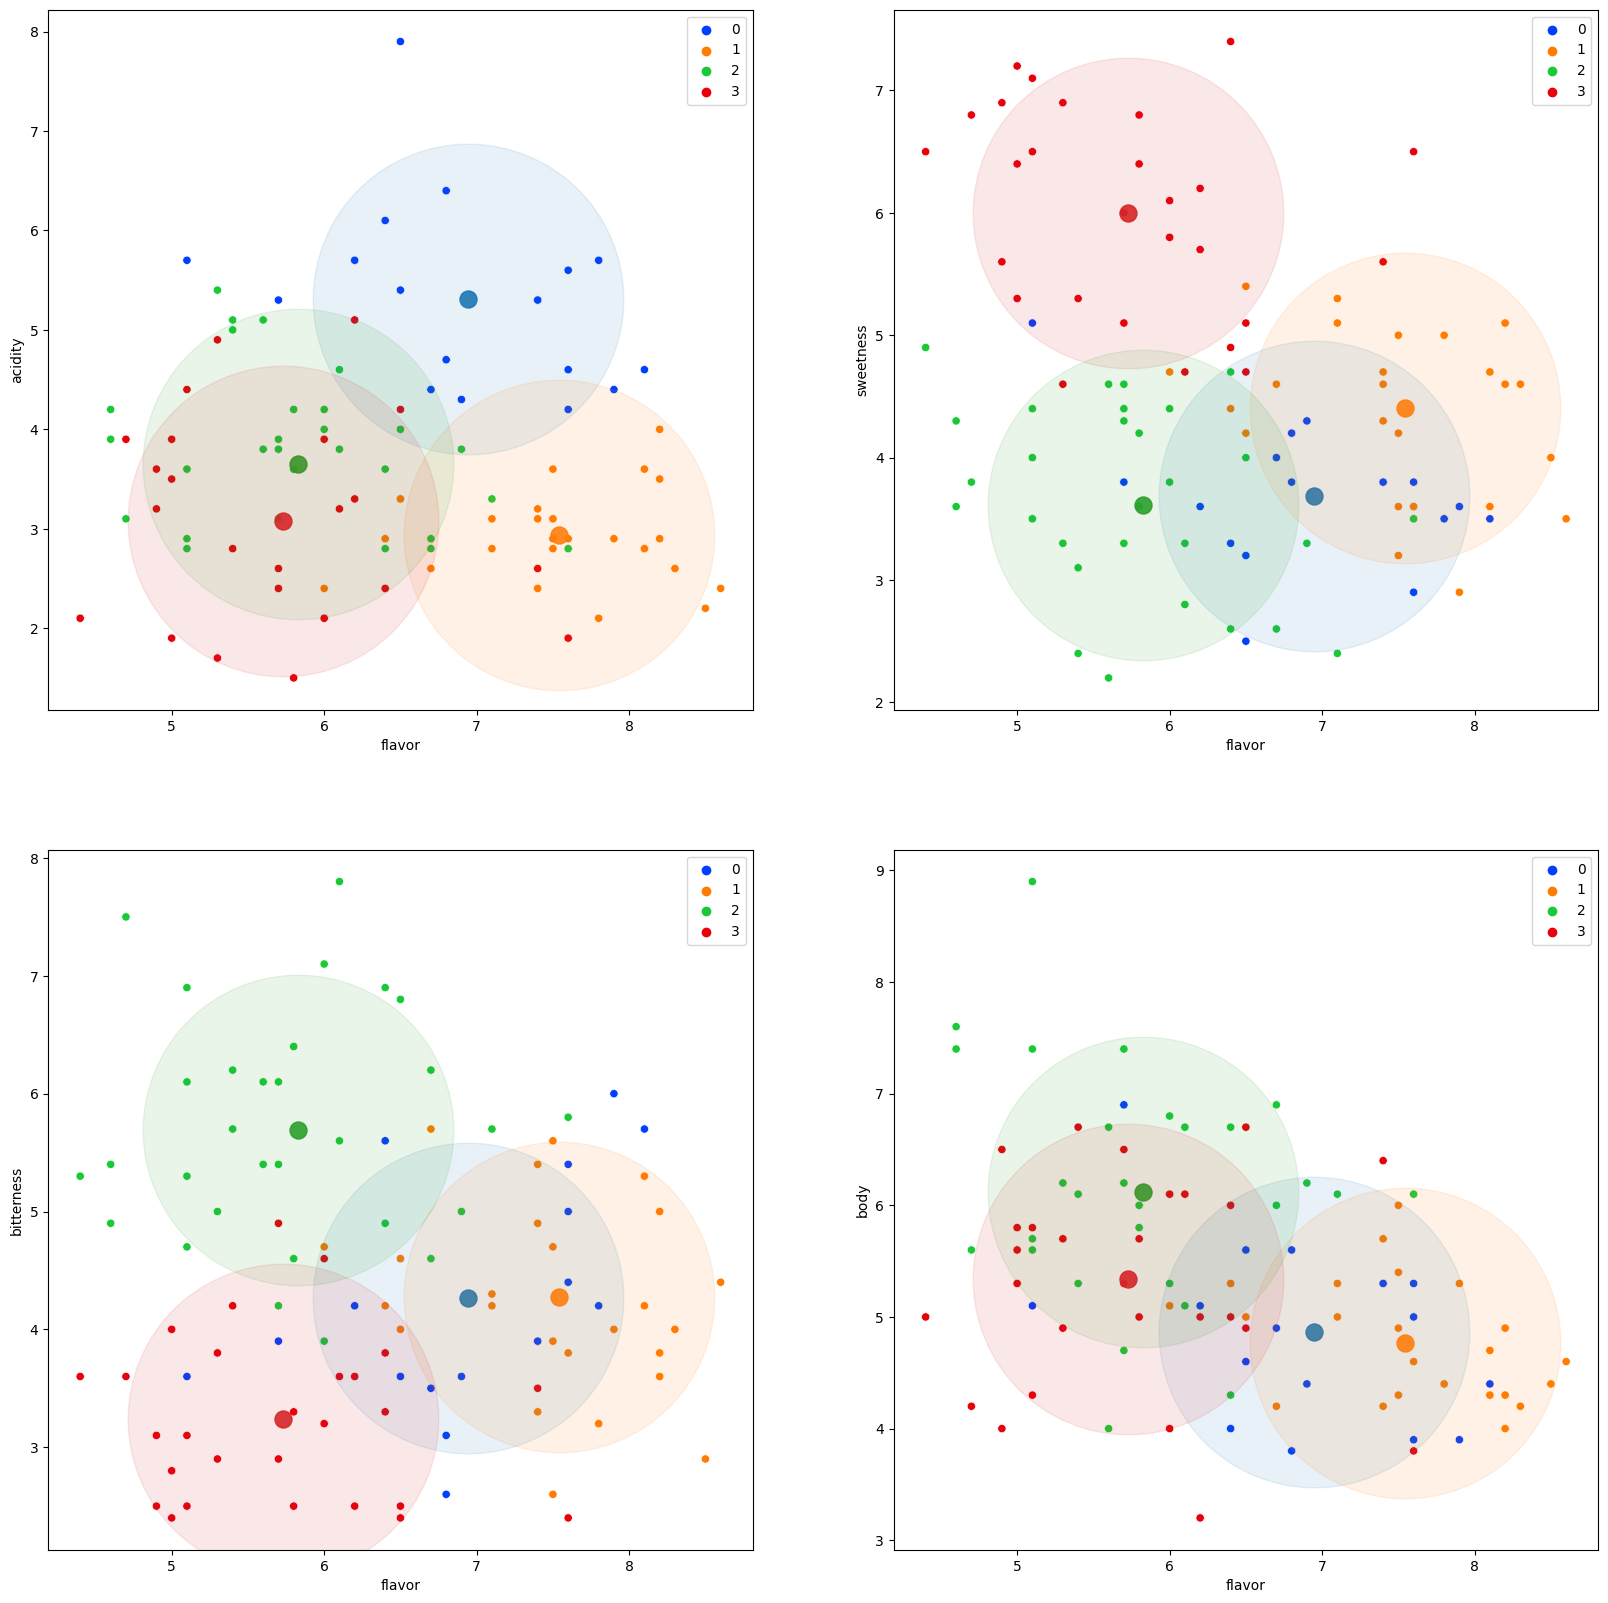

In [29]:
# scaling하지 않은 데이터를 학습하고 시각화하기
figs = 20
plt.figure(figsize=(figs, figs))

X = user_label_tf_clust_df

plt.subplot(221)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,1], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[1], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[1], c=color, alpha=0.1, s=figs*2500)

plt.subplot(222)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,2], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[2], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[2], c=color, alpha=0.1, s=figs*2500)

plt.subplot(223)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,3], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[3], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[3], c=color, alpha=0.1, s=figs*2500)

plt.subplot(224)
sns.scatterplot(x=X.iloc[:,0], y=X.iloc[:,4], data=user_label_tf_df, hue=clust_model.labels_, palette='bright')
for center, color in zip(centers, [x for x in mcolors.TABLEAU_COLORS]):
    plt.scatter(center[0], center[4], c=color, alpha=0.9, s=150)
    plt.scatter(center[0], center[4], c=color, alpha=0.1, s=figs*2500)

plt.show()

In [30]:
cluster_mean = user_label_tf_clust_df.groupby('clust').mean()
cluster_mean

,flavor,acidity,sweetness,bitterness,body
clust,,,,,
0,6.944444,5.311111,3.683333,4.266667,4.861111
1,7.540741,2.937037,4.403704,4.277778,4.762963
2,5.828125,3.656250,3.609375,5.693750,6.118750
3,5.728571,3.075000,5.996429,3.239286,5.342857


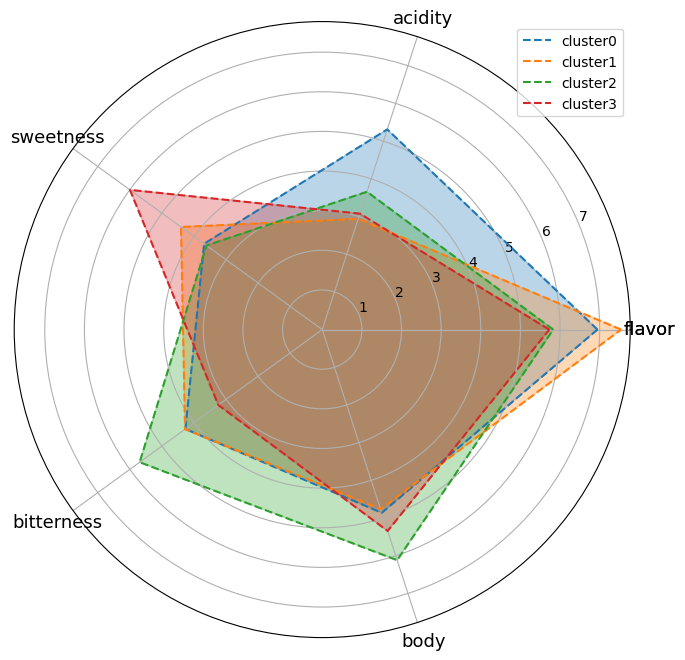

In [31]:
# radar로 cluster_k_mean 출력

categories = cluster_mean.columns[:]
categories = [*categories, categories[0]]

cluster = cluster_mean.apply(lambda x : [*list(x)[:], list(x)[0]], axis=1)

label_loc = np.linspace(start=0, stop=2*np.pi, num=len(cluster[0]))

plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)
plt.xticks(label_loc, labels=categories, fontsize=13)
plt.color_sequences
ax.plot(label_loc, cluster[0], label='cluster0', linestyle='dashed', color='tab:blue')
ax.fill(label_loc, cluster[0], color='tab:blue', alpha=0.3)
ax.plot(label_loc, cluster[1], label='cluster1', linestyle='dashed', color='tab:orange')
ax.fill(label_loc, cluster[1], color='tab:orange', alpha=0.3)
ax.plot(label_loc, cluster[2], label='cluster2', linestyle='dashed', color='tab:green')
ax.fill(label_loc, cluster[2], color='tab:green', alpha=0.3)
ax.plot(label_loc, cluster[3], label='cluster3', linestyle='dashed', color='tab:red')
ax.fill(label_loc, cluster[3], color='tab:red', alpha=0.3)
ax.legend()
plt.show()

In [32]:
user_label_tf_clust_df['1st_param'] = user_label_tf_clust_df.iloc[:, :6].apply(lambda x : x.idxmax(), axis=1)
user_label_tf_clust_df['2nd_param'] = user_label_tf_clust_df.iloc[:, :7].apply(lambda x : x.drop([x['1st_param'], '1st_param']).astype('float').idxmax(), axis=1)
user_label_tf_clust_df['result_code'] = user_label_tf_clust_df.iloc[:, 6:8].apply(lambda x : ''.join(map(str, user_label_tf_clust_df.columns.get_indexer(x.values)+1)), axis=1)
user_label_tf_clust_df.head()

,flavor,acidity,sweetness,bitterness,body,clust,1st_param,2nd_param,result_code
0,8.1,2.8,4.7,5.3,4.3,1,flavor,bitterness,14
1,5.0,1.9,6.4,2.4,5.8,3,sweetness,body,35
2,8.1,4.6,3.5,5.7,4.4,0,flavor,bitterness,14
3,4.6,4.2,3.6,4.9,7.6,2,body,bitterness,54
4,6.2,3.3,6.2,2.5,3.2,3,flavor,sweetness,13


In [33]:
print(user_label_tf_clust_df['result_code'].value_counts())
print(user_label_tf_clust_df[['clust', 'result_code']].value_counts(sort=False))

15    27
51    16
13    11
14    10
31     9
41     7
12     7
45     5
35     4
54     4
21     2
53     2
52     1
Name: result_code, dtype: int64
clust  result_code
0      12              7
       14              4
       15              4
       21              2
       51              1
1      13              7
       14              5
       15             15
2      14              1
       15              5
       41              7
       45              5
       51              9
       52              1
       54              4
3      13              4
       15              3
       31              9
       35              4
       51              6
       53              2
dtype: int64


In [34]:
clust_model.predict(cluster_mean.iloc[3].values.reshape(1, -1))

C:\Users\SSAFY\.virtualenvs\server-recom-DMAp1cuv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([3])

In [35]:
user_label_tf_clust_df.iloc[0, :-4]

flavor        8.1
acidity       2.8
sweetness     4.7
bitterness    5.3
body          4.3
Name: 0, dtype: object

In [36]:
clust_model.predict(user_label_tf_clust_df.iloc[0, :5].values.reshape(1, -1))

C:\Users\SSAFY\.virtualenvs\server-recom-DMAp1cuv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([1])

In [37]:
resultTypes = ["unknown", "향미에 가치를 두는 타입", "상쾌하고 산미가 강조된 맛을 좋아하는 타입", "달콤하고 즐거운 맛을 즐기는 타입", "강하고 쓴 맛을 선호하는 타입", "풍부하고 진한 입감을 즐기는 타입"]

In [38]:
params0_note = ["", "카라멜, 고소한, 풍부한", "견과류, 묵직한, 스모크", "과일, 초코, 균형있는", "견과류, 고소한, 중후한", ""]
params3_note = ["", "과일, 풍부한", "초코, 부드러운", "견과류, 고소한", "", ""]
params4_note = ["", "사과, 배", "체리, 복숭아", "베리, 커런트", "레몬, 오렌지, 귤", "망고, 바나나, 파인애플"]
params5_note = ["", "우디", "시트러스", "허브", "플로럴", "허니"]

In [39]:
user_label_tf_clust_df['result_type'] = user_label_tf_clust_df.apply(lambda x : resultTypes[int(x['result_code'][0])], axis=1)
user_label_tf_clust_df['coffeeing_note'] = user_label.apply(lambda x : params0_note[x.iloc[0]] + ', ' + params3_note[x.iloc[3]] + ', ' + params4_note[x.iloc[4]] + ', ' + params5_note[x.iloc[5]], axis=1)
user_label_tf_clust_df.head()

,flavor,acidity,sweetness,bitterness,body,clust,1st_param,2nd_param,result_code,result_type,coffeeing_note
0,8.1,2.8,4.7,5.3,4.3,1,flavor,bitterness,14,향미에 가치를 두는 타입,"카라멜, 고소한, 풍부한, 초코, 부드러운, 체리, 복숭아, 허브"
1,5.0,1.9,6.4,2.4,5.8,3,sweetness,body,35,달콤하고 즐거운 맛을 즐기는 타입,"카라멜, 고소한, 풍부한, 초코, 부드러운, 사과, 배, 허니"
2,8.1,4.6,3.5,5.7,4.4,0,flavor,bitterness,14,향미에 가치를 두는 타입,"견과류, 묵직한, 스모크, 과일, 풍부한, 베리, 커런트, 허브"
3,4.6,4.2,3.6,4.9,7.6,2,body,bitterness,54,풍부하고 진한 입감을 즐기는 타입,"견과류, 고소한, 중후한, 초코, 부드러운, 레몬, 오렌지, 귤, 우디"
4,6.2,3.3,6.2,2.5,3.2,3,flavor,sweetness,13,향미에 가치를 두는 타입,"카라멜, 고소한, 풍부한, 과일, 풍부한, 사과, 배, 플로럴"


In [40]:
# sql_member.csv
member_read = pd.read_csv(path.join(DIR_SAVE_PATH, 'sql_member.csv'), low_memory=False, encoding='utf-8')

print(member_read.shape)
member_read.head()

(1000, 12)


,idx,created_date,updated_date,age_range,expired,gender,hashcode,member_email,nickname,profileImg,role,sns_type
0,1,2023-03-01 12:00:00.000000,2023-03-01 12:00:00.000000,20~29,N,male,N36WH,kwonjiwoo8689@naver.com,권지우,http://k.kakaocdn.net/dn/dpk9l1/btqmGhA2lKL/Oz...,ROLE_MEMBER,KAKAO
1,2,2023-03-01 12:43:12.000000,2023-03-01 12:43:12.000000,20~29,N,male,5P868,jusang6794@gmail.com,홍주상,http://k.kakaocdn.net/dn/dpk9l1/btqmGhA2lKL/Oz...,ROLE_MEMBER,KAKAO
2,3,2023-03-01 13:26:24.000000,2023-03-01 13:26:24.000000,20~29,N,female,9MRTC,ohe9819@naver.com,오하은,http://k.kakaocdn.net/dn/dpk9l1/btqmGhA2lKL/Oz...,ROLE_MEMBER,KAKAO
3,4,2023-03-01 14:09:36.000000,2023-03-01 14:09:36.000000,20~29,N,male,MSNT1,kwonhahwan4662@gmail.com,권하환,http://k.kakaocdn.net/dn/dpk9l1/btqmGhA2lKL/Oz...,ROLE_MEMBER,KAKAO
4,5,2023-03-01 14:52:48.000000,2023-03-01 14:52:48.000000,50~59,N,female,VZ6XF,dongji9704@naver.com,임동지,http://k.kakaocdn.net/dn/dpk9l1/btqmGhA2lKL/Oz...,ROLE_MEMBER,KAKAO


In [41]:
survey_columns = ['idx', 'created_date', 'updated_date', 'acidity', 'bitterness', 'body', 'coffeeing_note', 'expired', 'flavor', 'param1', 'param2', 'param3', 'param4', 'param5', 'param6', 'param7', 'param8', 'result_code', 'result_type', 'sweetness', 'member_idx']
survey_df = pd.DataFrame(data=[([idx + 1] + [None for x in range(len(survey_columns) - 1)]) for idx in range(member_read.shape[0])], columns=survey_columns)
survey_df.head()

,idx,created_date,updated_date,acidity,bitterness,body,coffeeing_note,expired,flavor,param1,param2,param3,param4,param5,param6,param7,param8,result_code,result_type,sweetness,member_idx
0,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [42]:
rand_user_label = random.choices([i for i in range(user_label_tf_clust_df.shape[0])], k=survey_df.shape[0])

In [43]:
rand_user_label[:10]

[53, 63, 78, 58, 44, 89, 37, 66, 2, 99]

In [44]:
survey_df['created_date'] = member_read['created_date']
survey_df['updated_date'] = member_read['updated_date']
survey_df['expired'] = member_read['expired']
survey_df['member_idx'] = member_read['idx']

gender_params = {'male':1, 'female':2}
survey_df['param1'] = member_read['gender'].apply(lambda x : gender_params[x])

age_params = {'00~00':0, '10~19':1, '20~29':2, '30~39':3, '40~49':4, '50~59':5}
survey_df['param2'] = member_read['age_range'].apply(lambda x : age_params[x])

survey_df[['param3', 'param4', 'param5', 'param6', 'param7', 'param8']] = member_read.apply(lambda x: user_label.iloc[rand_user_label[x.idx-1]], axis=1)

survey_df[['acidity', 'bitterness', 'body', 'coffeeing_note', 'flavor', 'result_code', 'result_type', 'sweetness']] = member_read.apply(lambda x: user_label_tf_clust_df.iloc[rand_user_label[x.idx-1]][['acidity', 'bitterness', 'body', 'coffeeing_note', 'flavor', 'result_code', 'result_type', 'sweetness']], axis=1)

survey_df.head()

,idx,created_date,updated_date,acidity,bitterness,body,coffeeing_note,expired,flavor,param1,param2,param3,param4,param5,param6,param7,param8,result_code,result_type,sweetness,member_idx
0,1,2023-03-01 12:00:00.000000,2023-03-01 12:00:00.000000,3.5,2.8,5.3,"카라멜, 고소한, 풍부한, 초코, 부드러운, 망고, 바나나, 파인애플, 시트러스",N,5.0,1,2,1,3,3,2,5,2,35,달콤하고 즐거운 맛을 즐기는 타입,7.2,1
1,2,2023-03-01 12:43:12.000000,2023-03-01 12:43:12.000000,3.3,2.5,6.7,"견과류, 묵직한, 스모크, 과일, 풍부한, 망고, 바나나, 파인애플, 플로럴",N,6.5,1,2,2,5,3,1,5,4,51,풍부하고 진한 입감을 즐기는 타입,4.7,2
2,3,2023-03-01 13:26:24.000000,2023-03-01 13:26:24.000000,4.2,5.4,5.3,"견과류, 묵직한, 스모크, 초코, 부드러운, 레몬, 오렌지, 귤, 허브",N,7.6,2,2,2,1,1,2,4,3,14,향미에 가치를 두는 타입,3.8,3
3,4,2023-03-01 14:09:36.000000,2023-03-01 14:09:36.000000,4.0,3.8,4.0,"과일, 초코, 균형있는, 과일, 풍부한, 체리, 복숭아, 허브",N,8.2,1,2,3,1,2,1,2,3,13,향미에 가치를 두는 타입,5.1,4
4,5,2023-03-01 14:52:48.000000,2023-03-01 14:52:48.000000,4.9,2.9,5.7,"카라멜, 고소한, 풍부한, 초코, 부드러운, 레몬, 오렌지, 귤, 시트러스",N,5.3,2,5,1,5,4,2,4,2,51,풍부하고 진한 입감을 즐기는 타입,4.6,5


In [45]:
# 파일 저장
os.makedirs(DIR_SAVE_PATH, exist_ok=True)
survey_df.to_csv(path.join(DIR_SAVE_PATH, 'sql_survey_new.csv'), sep=',', index=False, encoding='utf-8')